In [1]:
import sys
import urllib.request
import json
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

# optional for promoter intersection experiment
import pyranges
import trgt

One of the TRGTdb queries is `methyl` which returns CpG stats on alleles as well as their average methylation level across samples. Tandem repeats have been implicated to have a role in transcription ([ref](https://pubmed.ncbi.nlm.nih.gov/19478187/#:~:text=Tandem%20repeats%20are%20variable%20elements,by%20affecting%20local%20chromatin%20structure.)), methylation also may have a role in gene expression ([ref](https://www.nature.com/scitable/topicpage/the-role-of-methylation-in-gene-expression-1070/)), and "More than 50% of human genes initiate transcription from CpG dinucleotide-rich regions referred to as CpG islands." ([ref](https://genomebiology.biomedcentral.com/articles/10.1186/gb-2012-13-11-r110)). 

By the end of this tutorial, you will:
- Understand TRGTdb's methylation/CpG query
- Know how to use pyranges to annotate the TRGTdb Loci with reference information
- See interesting patterns with repsect to tandem repeats, CpG islands, methylation levels, and promoters

# The methyl query

First we'll open up our `hprc_105.tdb` and run the `methyl` query.

In [2]:
data = trgt.load_tdb("../test_files/databases/hprc_105.tdb/",
                    lfilters=[("chrom", "==", "chr10")]) # Only pull chr10 for speed
methyl = trgt.methyl(data)
methyl.head()

,LocusID,allele_number,allele_length,average_methylation,CpG_obs,CpG_exp,CpG_density,GC_pct
0,77193,2,79,NaN,0,1.151899,0.000000,0.253165
1,77193,3,80,NaN,0,1.137500,0.000000,0.250000
2,77194,3,83,176.0,2,1.325301,0.048193,0.253012
3,77194,4,85,167.0,2,1.294118,0.047059,0.247059
4,77196,0,95,159.0,0,2.526316,0.000000,0.336842


The methyl query's output is on a per-Allele basis and has the columns
- LocusID : The allele's locus
- allele_number : The allele number at the locus
- allele_length : The length of the allele
- average_methylation : The average `average_methylation` across all samples in which the allele was observed
- CpG_obs : The number of 'CG' dinucleoties observed in the allele_sequence
- CpG_exp : The expected number of CGs in the allele_sequence calculted as `(c_count * g_count) / len(seq)`
- CpG_density : The CpG density calculated as `obs * 2 / len(seq)`
- GC_pct : The GC% of the sequence calculated as `(c_count + g_count) / len(seq)`

Let's look at the relationship between `CpG_density` and `average_methylation` for our alleles.

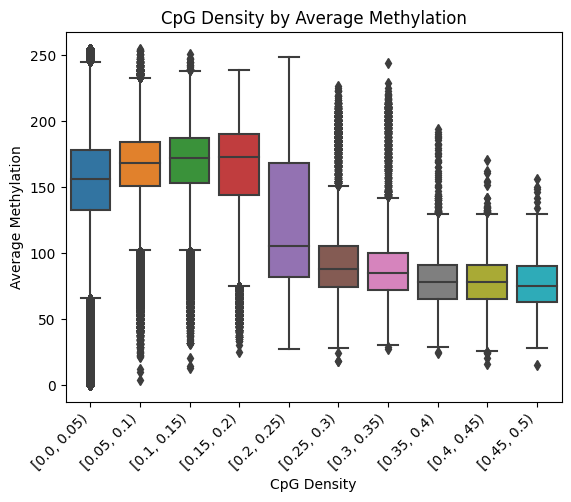

In [3]:
bins = [_ / 100 for _ in range(0, 51, 5)] # Binning to help visualize
methyl['CpGbin'] = pd.cut(methyl['CpG_density'], bins, right=False)
p = sb.boxplot(data=methyl, x="CpGbin", y="average_methylation")
p.set(title="CpG Density by Average Methylation", xlabel="CpG Density", ylabel="Average Methylation")
_ = plt.xticks(rotation=45, ha='right')

The resulting distribution of methylation levels is consistent with the expected human genome methylation profile: CpG denser regions had markedly lower methylation compared to the CpG sparser regions.

We can annotate our alleles as being 'CpG_islands' when their CpG Obs/Exp value is greater than 0.6 and the GC content is greater than 50% ([ref](https://www.bioinformatics.org/sms2/cpg_islands.html)). Then we'll make another boxplot to see if there might be a relationship between average methylation and CpG islands

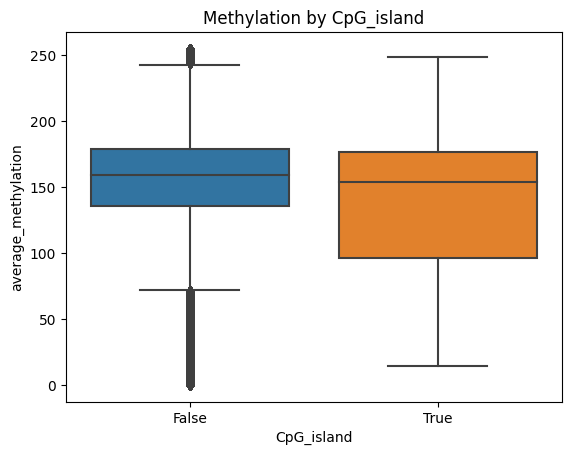

In [4]:
methyl['CpG_island'] = (methyl['GC_pct'] > 0.50) & ((methyl['CpG_obs'] / methyl['CpG_exp']) > 0.60)

p = sb.boxplot(data=methyl, x="CpG_island", y="average_methylation")
_ = p.set(title="Methylation by CpG_island")

The `CpG_island` methylation distribution look like it might be interesting. Looking at those alleles in detail below we see that it appears to have a bimodal distribution.

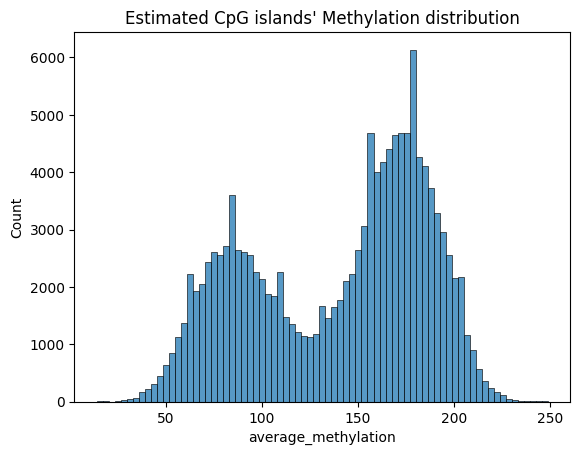

In [5]:
p = sb.histplot(data=methyl[methyl["CpG_island"]].reset_index(), x="average_methylation")
_ = p.set(title="Estimated CpG islands' Methylation distribution")

# TRs in Promoters

Let's change gears a little bit and talk about how to annotate and/or subset our TRGTdb by reference annotations. To accomplish this, we'll use the EPD as our list of promoters [ref](https://academic.oup.com/nar/article/41/D1/D157/1070274?login=false) and pull them from UCSC.

In [6]:
url = "https://api.genome.ucsc.edu/getData/track?genome=hg38;track=epdNewPromoter;chrom=chr10"
with urllib.request.urlopen(url) as response:
   html = response.read()
promoters = pd.DataFrame(json.loads(html)['epdNewPromoter'])
promoters.head()

,chrom,chromStart,chromEnd,name,score,strand,thickStart,thickEnd
0,chr10,76627,76687,TUBB8_1,900,-,76627,76638
1,chr10,134434,134494,ZMYND11_3,900,+,134483,134494
2,chr10,134750,134810,ZMYND11_2,900,+,134799,134810
3,chr10,135215,135275,ZMYND11_4,900,+,135264,135275
4,chr10,135405,135465,ZMYND11_1,900,+,135454,135465


Now we'll use PyRanges to find which of the TRs intersect with promoters. PyRanges expects specific column names for the reference coordinates of ranges, so we'll need to do a `.rename`.

In [7]:
loci = pyranges.PyRanges(data['locus'].rename(columns={"chrom":"Chromosome",
                                                       "start":"Start",
                                                       "end":"End"}))
prom = pyranges.PyRanges(promoters.rename(columns={"chrom":"Chromosome",
                                                       "chromStart":"Start",
                                                       "chromEnd":"End"}))
# Subset of loci which overlap promoters
subset = loci.overlap(prom)
print(len(subset), "TR loci intersect with promoters")

109 TR loci intersect with promoters


Let's annotate our `methyl` summary table with if each allele is inside a locus which intersects a promoter. Then we can check average_methylation and CpG_density by the alleles' promoter status.

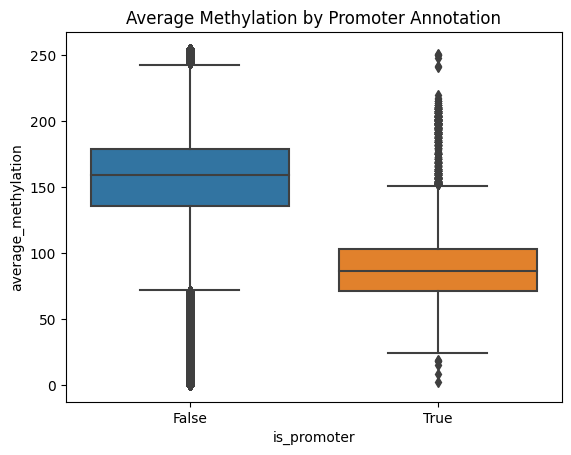

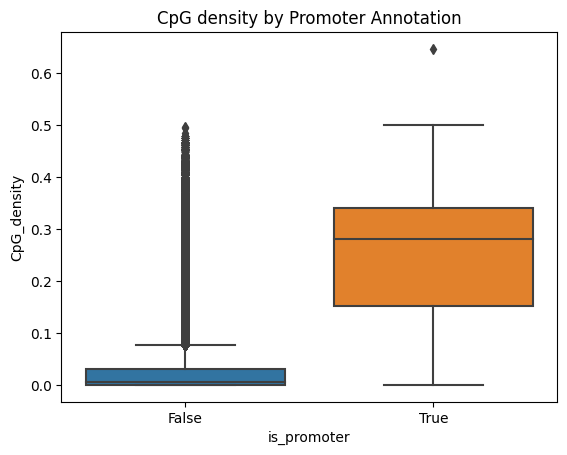

In [8]:
# Note we have to use `subset.df` since subset is a PyRanges object
methyl['is_promoter'] = methyl["LocusID"].isin(subset.df["LocusID"])

p = sb.boxplot(data=methyl, x="is_promoter", y="average_methylation")
_ = p.set(title="Average Methylation by Promoter Annotation")
plt.show()

p = sb.boxplot(data=methyl, x="is_promoter", y="CpG_density")
_ = p.set(title="CpG density by Promoter Annotation")
plt.show()

As expected, the alleles in TRs intersecting promoters have a lower `average_methylation` and higher `CpG_density`

Let's also do a quick Fisher exact test to see if there's a relationship between is_promoter and CpG_islands. To do this, we'll need to count by Loci instead of the per-allele which is currently in our `methyl` table.

In [9]:
import scipy.stats as stats

keys = ["LocusID", "is_promoter", "CpG_island"]
matrix = (methyl.sort_values(keys)
              .drop_duplicates(subset=keys) # Deduplicate alleles per-locus
              .groupby(['is_promoter', 'CpG_island'])
              .size().unstack())

print("Fisher Exact Test ->", stats.fisher_exact(matrix))
matrix

Fisher Exact Test -> SignificanceResult(statistic=155.05736981465137, pvalue=1.963138522432751e-117)


CpG_island,False,True
is_promoter,,
False,43920,1133
True,22,88


Now, we'll go back to our bimodal distribution in the previous section and separate out the alleles which are `in_promoter` from the rest.

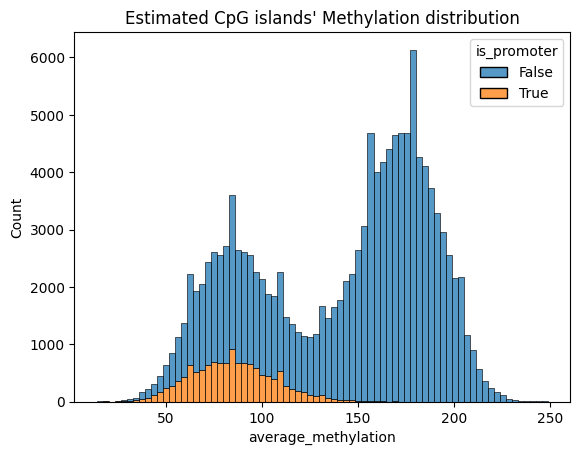

In [10]:
p = sb.histplot(data=methyl[methyl["CpG_island"]].reset_index(),
                x="average_methylation", 
                hue="is_promoter",
                multiple="stack")
_ = p.set(title="Estimated CpG islands' Methylation distribution")

We see that at least part of our bimodal distribution is explained by the lower average_methylation CpG islands being from alleles which intersect promoters.